**Using the user-based collaborative filtering approach to build a recommendation system on:**

**The Taste Profile Subset (UserID, song ID and playCount) curated by EchoNest**

**Step 1. Loading the dataset and imports.**

Taste Profile Subset reference: http://millionsongdataset.com/tasteprofile/


The Taste profile Subset dataset was downloaded from: http://millionsongdataset.com/sites/default/files/challenge/train_triplets.txt.zip

In [55]:
#Granting access to the google drive folder where the dataset is stored.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
# Defining the path in drive where the dataset is stored
file_path ='/content/drive/My Drive/recommendation system/train_triplets.txt'

In [83]:
#Installing the required libraries

# Surprise library in python is used for recommendation systems.
!pip install scikit-surprise

In [119]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr

In [120]:
# Load the dataset into a pandas dataframe 'songs' with column names:  user, song and play_count.
songs = pd.read_csv(file_path, sep="\t", nrows=10000, names=['userID', 'songID', 'play_count'], header=None)

In [121]:
# Printing the first 5 rows in the dataset.
print(songs.head(5))

                                     userID              songID  play_count
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9           1
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B           2
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22           1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494           1


**Step 2. Exploring the Data.**

In [122]:
# Check for missing values
missing_values = songs.isnull().sum()

# Display columns with missing values
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [123]:
# Printing the shape of the dataset.
print(songs.shape)

(10000, 3)


We can see that the dataset has 10000 rows and 3 columns - userID, songID and the play_count and that it has no missing values.

**2.1 Checking for unique rows and duplicates in the dataset.**

In [124]:
unique_rows = songs.drop_duplicates().shape[0]
# Printing the number of unique rows
print("Number of unique rows:", unique_rows)

Number of unique rows: 10000


In [125]:
# Checking for duplicates column wise.
duplicates = songs.duplicated()
print("Duplicates in the dataset:")
print(songs[duplicates])

Duplicates in the dataset:
Empty DataFrame
Columns: [userID, songID, play_count]
Index: []


**2.2 Finding the range and min-max of the play_count column.**

In [126]:
print("Max value in play_counts column: {}".format(songs['play_count'].max()))
print("Min value in play_counts column: {}".format(songs['play_count'].min()))

Max value in play_counts column: 140
Min value in play_counts column: 1


In [127]:
print("Play Counts are in the range of: {} - {}".format(songs['play_count'].min(), songs['play_count'].max()))

Play Counts are in the range of: 1 - 140


**2.3 Visualizing the play_count column's distribution (initial).**

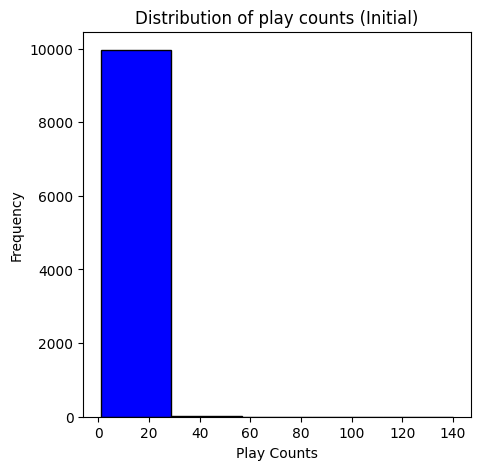

In [128]:
# Plotting the distribution
plt.figure(figsize=(5, 5))
plt.hist(songs['play_count'], bins=5, color='blue', edgecolor='black')
plt.title(f'Distribution of play counts (Initial)')
plt.xlabel('Play Counts')
plt.ylabel('Frequency')
plt.show()

**2.4 Getting the quartile distribution for the play_counts column.**

In [129]:
column_name = 'play_count'
# Get quartile distributions
quartiles = songs[column_name].describe(percentiles=[.25, .5, .75])
print("Quartile Distributions for {}:\t{}".format(column_name, quartiles))

Quartile Distributions for play_count:	count    10000.000000
mean         2.522300
std          4.444736
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        140.000000
Name: play_count, dtype: float64


From the above analysis we can see that:

The mean play_count is 2.52 and the standard deviation is 4.44.

25% of the data has play count values of 1 or less and the median of the play_counts is 1.

The play_counts column seems to have skewed distribution between the range 1-140.

Since the distribution is skewed, we'll apply z-score normalization to the play_count column. This will make sure that the play_count variable now has a mean of 0 and standard deviation of 1. The distribution will retain its shape, but the scale will be changed.


**2.5 Z-score Normalization for the play_count variable.**

In [130]:
play_count_column = songs[['play_count']]

# Initialize the StandardScaler - for z score normalization.
scaler = StandardScaler()

# Fit and transform the data
normalized_play_count = scaler.fit_transform(play_count_column)

# Replace the original 'play_count' column with the normalized values
songs['normalized_play_count'] = normalized_play_count

# Drop the original play_count column.
songs = songs.drop('play_count', axis=1)

# Print the normalized DataFrame
print(songs)

                                        userID              songID  \
0     b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995   
1     b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9   
2     b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B   
3     b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22   
4     b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494   
...                                        ...                 ...   
9995  8caf9a87e266a22298bd977a63489d008af241c5  SOETKSY12A8C13C666   
9996  8caf9a87e266a22298bd977a63489d008af241c5  SOFPXJZ12A6D4F6444   
9997  8caf9a87e266a22298bd977a63489d008af241c5  SOFRCGW12A81C21EA6   
9998  8caf9a87e266a22298bd977a63489d008af241c5  SOFUVPZ12A6D4FCEA3   
9999  8caf9a87e266a22298bd977a63489d008af241c5  SOGKCNH12A8C139F79   

      normalized_play_count  
0                 -0.342512  
1                 -0.342512  
2                 -0.117516  
3                 -0.342512  
4        

**2.6 Visualization of the play_count column after normalization.**

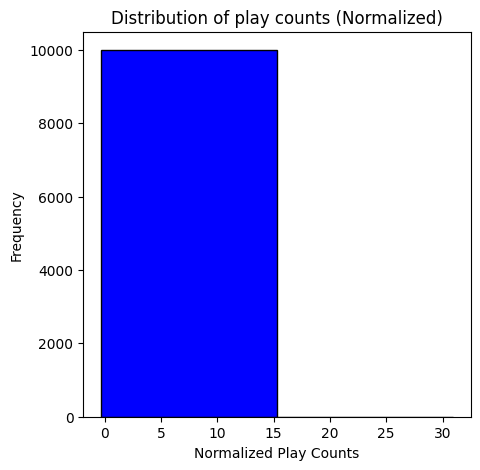

In [131]:
# Plotting the distribution
plt.figure(figsize=(5, 5))
plt.hist(songs['normalized_play_count'], bins=2, color='blue', edgecolor='black')
plt.title(f'Distribution of play counts (Normalized)')
plt.xlabel('Normalized Play Counts')
plt.ylabel('Frequency')
plt.show()

**Step 3. Dividing the data into training, validation and test set.**

In [132]:
train_data, test_data = train_test_split(songs, test_size=0.2, random_state=71)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=17)

In [133]:
print("No of rows in training data: {}".format(train_data.shape[0]))
print("No of rows in validation data: {}".format(val_data.shape[0]))
print("No of rows in testing data: {}".format(test_data.shape[0]))

No of rows in training data: 6400
No of rows in validation data: 1600
No of rows in testing data: 2000


**Step 4. Building the user-item matrix.**

In [134]:
# Create user-item matrix for train, val, and test sets
user_item_matrix_train = train_data.pivot(index='userID', columns='songID', values='normalized_play_count').fillna(0)
user_item_matrix_val = val_data.pivot(index='userID', columns='songID', values='normalized_play_count').fillna(0)
user_item_matrix_test = test_data.pivot(index='userID', columns='songID', values='normalized_play_count').fillna(0)

**Step 5. Using a similarity measure to calculate the similarity between users.**

In [152]:
# Compute cosine similarity
cosine_similarity_matrix = cosine_similarity(user_item_matrix_train.T)

# Compute Pearson correlation coefficient
pearson_similarity_matrix = user_item_matrix_train.T.corr(method='pearson')

**Step 6. Neighborhood Selection.**

In [181]:
k = 5  # Number of neighbors

# Get top-k neighbors for each item using cosine similarity
top_cosine_neighbors = np.argsort(cosine_similarity_matrix, axis=1)[:, -k:]

# Get top-k neighbors for each item using Pearson similarity
top_pearson_neighbors = np.argsort(pearson_similarity_matrix.values, axis=1)[:, -k:]

In [182]:
print("Data type of top_cosine_neighbors:", top_cosine_neighbors.dtype)
print("Data type of top_pearson_neighbors:", top_pearson_neighbors.dtype)

Data type of top_cosine_neighbors: int64
Data type of top_pearson_neighbors: int64


**Step 7. Making predictions.**

In [183]:
# Predict using the neighborhood for cosine similarity
cosine_predictions = np.dot(user_item_matrix_train, cosine_similarity_matrix)

In [184]:
# Predict using the neighborhood for Pearson similarity
pearson_predictions = np.dot(pearson_similarity_matrix, user_item_matrix_train)

**Step 8. Generate top N recommendations.**

In [185]:
def get_top_n_recommendations(predictions, n=10):
    # Identify the top N recommendations for each user
    top_n_recommendations = np.argsort(predictions, axis=1)[:, -n:]
    return top_n_recommendations

In [186]:
# Get top N recommendations for both cosine and Pearson predictions
top_n_cosine = get_top_n_recommendations(cosine_predictions)
top_n_pearson = get_top_n_recommendations(pearson_predictions)

**Step 9. Evaluation on the training and validation set using the RMSE metric.**

In [187]:
def calculate_rmse(predictions, actual):
    # Extract non-zero elements for comparison
    predicted_values = predictions[actual.nonzero()].flatten()
    actual_values = actual[actual.nonzero()].flatten()

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(predicted_values, actual_values))
    return rmse

In [188]:
# Calculate RMSE for train and val sets
rmse_cosine_train = calculate_rmse(cosine_predictions, user_item_matrix_train.values)
rmse_cosine_val = calculate_rmse(cosine_predictions, user_item_matrix_val.values)

rmse_pearson_train = calculate_rmse(pearson_predictions, user_item_matrix_train.values)
rmse_pearson_val = calculate_rmse(pearson_predictions, user_item_matrix_val.values)

print("RMSE (Cosine) - Train:", rmse_cosine_train, "Validation:", rmse_cosine_val)
print("RMSE (Pearson) - Train:", rmse_pearson_train, "Validation:", rmse_pearson_val)

RMSE (Cosine) - Train: 46.748448894575404 Validation: 3.1837090947988624
RMSE (Pearson) - Train: 0.28510219690908095 Validation: 0.9701738159034171


**Step 10.Fine-tune the algorithm to improve RMSE - Experiment with different values of the neighborhood**

In [159]:
# Define a range of values for k
k_values = [5, 10, 15, 20]

# Initialize variables to store RMSE values
rmse_cosine_values = []
rmse_pearson_values = []

print("Testing different neighborhood values for the validation data")
# Iterate over different values of k
for k in k_values:
    # Update top-k neighbors for both cosine and Pearson similarity
    top_cosine_neighbors = np.argsort(cosine_similarity_matrix, axis=1)[:, -k:]
    top_pearson_neighbors = np.argsort(pearson_similarity_matrix.values, axis=1)[:, -k:]

    # Update predictions
    cosine_predictions = np.dot(user_item_matrix_train, cosine_similarity_matrix)
    pearson_predictions = np.dot(pearson_similarity_matrix, user_item_matrix_train)

    # Calculate RMSE for validation set
    rmse_cosine_val = calculate_rmse(cosine_predictions, user_item_matrix_val.values)
    rmse_pearson_val = calculate_rmse(pearson_predictions, user_item_matrix_val.values)

    rmse_cosine_values.append(rmse_cosine_val)
    rmse_pearson_values.append(rmse_pearson_val)

    print(f"K value: {k}, RMSE-Cosine: {rmse_cosine_val}, RMSE-Pearson: {rmse_pearson_val}")




Testing different neighborhood values for the validation data
K value: 5, RMSE-Cosine: 3.1837090947988624, RMSE-Pearson: 0.9701738159034171
K value: 10, RMSE-Cosine: 3.1837090947988624, RMSE-Pearson: 0.9701738159034171
K value: 15, RMSE-Cosine: 3.1837090947988624, RMSE-Pearson: 0.9701738159034171
K value: 20, RMSE-Cosine: 3.1837090947988624, RMSE-Pearson: 0.9701738159034171


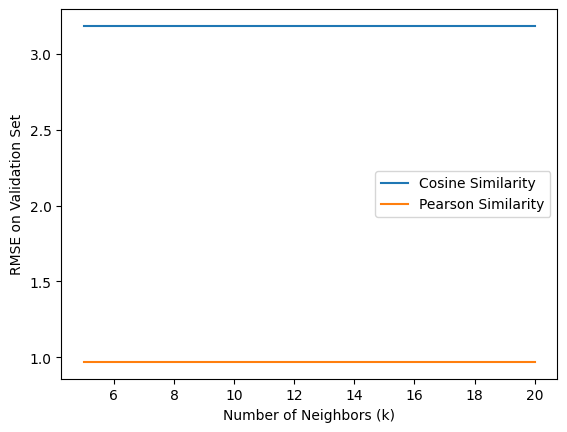

In [160]:
# Plot the results
plt.plot(k_values, rmse_cosine_values, label='Cosine Similarity')
plt.plot(k_values, rmse_pearson_values, label='Pearson Similarity')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE on Validation Set')
plt.legend()
plt.show()

From the above experiment we can see that changing the neighborhood values  doesn't impact the RMSE scores much. This maybe due to the underlying nature of data which doesn't change much when we select top n neighbors.

**Step 11. Evaluating the model on Test data.**

In [162]:
# Selecting k value as 5 based on above experiments.
best_k_cosine = 5
best_k_pearson = 5

# Get top-k neighbors for each item using cosine similarity
top_cosine_neighbors = np.argsort(cosine_similarity_matrix, axis=1)[:, -best_k_cosine:]

# Get top-k neighbors for each item using Pearson similarity
top_pearson_neighbors = np.argsort(pearson_similarity_matrix.values, axis=1)[:, -best_k_pearson:]

# Predict using the neighborhood for cosine similarity
cosine_predictions = np.dot(user_item_matrix_train, cosine_similarity_matrix)

# Predict using the neighborhood for Pearson similarity
pearson_predictions = np.dot(pearson_similarity_matrix, user_item_matrix_train)

# Calculate RMSE for test set
rmse_cosine_test = calculate_rmse(cosine_predictions, user_item_matrix_test.values)
rmse_pearson_test = calculate_rmse(pearson_predictions, user_item_matrix_test.values)

print("RMSE (Cosine) on Test:", rmse_cosine_test)
print("RMSE (Pearson) on Test:", rmse_pearson_test)

RMSE (Cosine) on Test: 4.337042410553731
RMSE (Pearson) on Test: 1.0934940037702052


**Step 12. Take userID as input from the user and generate recommendations for it.**

In [174]:
def get_top_recommendations_cosine(user_id_input_str, train_data, user_item_matrix_train, top_n=10):
    # Get the index corresponding to the userID
    user_id_index = train_data[train_data['userID'] == user_id_input_str].index

    if not user_id_index.empty:
        user_id_index = user_id_index[0]

        # Compute cosine similarity
        cosine_similarity_matrix = cosine_similarity(user_item_matrix_train.T)

        # Predict using the neighborhood for cosine similarity
        cosine_predictions = np.dot(user_item_matrix_train, cosine_similarity_matrix)

        # Extract the predicted ratings for the target user
        user_cosine_predictions = cosine_predictions[user_id_index, :]

        # Create a DataFrame with the predicted ratings for each song
        predicted_ratings_cosine_df = pd.DataFrame({'song': user_item_matrix_train.columns, 'predicted_rating': user_cosine_predictions})

        # Sort the DataFrame by predicted ratings in descending order
        predicted_ratings_cosine_df = predicted_ratings_cosine_df.sort_values(by='predicted_rating', ascending=False)

        # Display the top N recommendations
        top_recommendations_cosine = predicted_ratings_cosine_df.head(top_n)

        return top_recommendations_cosine
    else:
        print(f"User {user_id_input_str} not found in the training data.")
        return None


In [176]:
user_id_input = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
top_recommendations_cosine = get_top_recommendations_cosine(user_id_input, train_data, user_item_matrix_train)
if top_recommendations_cosine is not None:
    print(f"Top Recommendations for User {user_id_input} (Cosine):\n")
    print(top_recommendations_cosine)

Top Recommendations for User b80344d063b5ccb3212f76538f3d9e43d87dca9e (Cosine):

                    song  predicted_rating
0     SOAAAGQ12A8C1420C8         33.837002
3158  SOPABZM12A6D4FC668         33.837002
3476  SOQPGDF12AB01858C5         33.837002
5091  SOYTZBN12AB0187A0C         33.837002
3136  SOOXDIJ12A6D4FDE33         33.837002
1693  SOIBCIC12A58A7B55B         33.837002
3009  SOOHWRZ12AC468BA59         33.837002
4539  SOVYNVS12AC3DF64AB         33.837002
4562  SOWBMHX12A8C13851C         33.837002
3545  SOQZYQH12A8AE468E5         33.837002


In [177]:
user_id_input = 'abc'
top_recommendations_cosine = get_top_recommendations_cosine(user_id_input, train_data, user_item_matrix_train)
if top_recommendations_cosine is not None:
    print(f"Top Recommendations for User {user_id_input} (Cosine):\n")
    print(top_recommendations_cosine)

User abc not found in the training data.


In [178]:
def get_top_recommendations_pearson(user_id_input_str, train_data, user_item_matrix_train, top_n=10):
    # Get the index corresponding to the userID
    user_id_index = train_data[train_data['userID'] == user_id_input_str].index

    if not user_id_index.empty:
        user_id_index = user_id_index[0]

        # Compute Pearson correlation coefficient
        pearson_similarity_matrix = user_item_matrix_train.T.corr(method='pearson')

        # Predict using the neighborhood for Pearson similarity
        pearson_predictions = np.dot(pearson_similarity_matrix, user_item_matrix_train)

        # Extract the predicted ratings for the target user
        user_pearson_predictions = pearson_predictions[user_id_index, :]

        # Create a DataFrame with the predicted ratings for each song
        predicted_ratings_pearson_df = pd.DataFrame({'song': user_item_matrix_train.columns, 'predicted_rating': user_pearson_predictions})

        # Sort the DataFrame by predicted ratings in descending order
        predicted_ratings_pearson_df = predicted_ratings_pearson_df.sort_values(by='predicted_rating', ascending=False)

        # Display the top N recommendations
        top_recommendations_pearson = predicted_ratings_pearson_df.head(top_n)

        return top_recommendations_pearson
    else:
        print(f"User {user_id_input_str} not found in the training data.")
        return None

In [179]:
user_id_input = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
top_recommendations_pearson = get_top_recommendations_pearson(user_id_input, train_data, user_item_matrix_train)
if top_recommendations_pearson is not None:
    print(f"Top Recommendations for User {user_id_input} (Pearson):\n")
    print(top_recommendations_pearson)

Top Recommendations for User b80344d063b5ccb3212f76538f3d9e43d87dca9e (Pearson):

                    song  predicted_rating
3545  SOQZYQH12A8AE468E5          6.632379
2552  SOMEIDU12AB0182205          5.282400
1953  SOJIJWG12AAF3B46C0          2.807439
3915  SOSXLTC12AF72A7F54          2.194029
3158  SOPABZM12A6D4FC668          1.907453
494   SOCIHMS12A8C142CC7          1.682456
4467  SOVPBWS12A8C141EF1          1.682456
2565  SOMGIYR12AB0187973          1.503864
4839  SOXKGUD12A58A7C687          0.783873
5027  SOYIZSN12A6701E0BB          0.581311


In [180]:
user_id_input = 'abc'
top_recommendations_pearson = get_top_recommendations_pearson(user_id_input, train_data, user_item_matrix_train)
if top_recommendations_pearson is not None:
    print(f"Top Recommendations for User {user_id_input} (Pearson):\n")
    print(top_recommendations_pearson)

User abc not found in the training data.


-- Anusha Kalbande (002763017)